# Plan
Dla wszystkich 7:
- macierz korelacji
- klasteryzacja
- rzutowanie klasteryzacji na przestrzenie 3d
- elementy nietypowe ?

Dla net / eq, net / tangible, debt / assets:
- parami z debt / assets elementy nietypowe
- parami z debt / assets dopasowanie krzywej
- scatter wszystkich w 3d

Dla marketcap, E/P, spread, volume * price
- wykres P/E jako wstęp dlaczego użyliśmy E/P
- para E/P + marketcap, dopasowanie krzywej
- wyjaśnienie kształtu rozkładu (gauss z odcienciem n osi y dla y < 0)
- parami / trójkami(3d) scatter i elementy nietypowe

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
from datetime import datetime
import random
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Helper funcions

In [4]:
def get_fig_ax(num_rows=1, num_cols=1, figsize=(6, 4)):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Add grid to all plots
    if num_rows == 1 and num_cols == 1:
        ax.grid(True, which='both')
    elif num_rows != 1 and num_cols != 1:
        for i in range(num_rows):
            for j in range(num_cols):
                ax[i, j].grid(True, which='both')
    else:
        for i in range(max(num_rows, num_cols)):
            ax[i].grid(True, which='both')

    return fig, ax

In [5]:
def get_latest_timestamp(timestamps):
    latest_timestamp = 0
    for timestamp in timestamps:
        timestamp = int(timestamp)
        if timestamp > latest_timestamp:
            latest_timestamp = timestamp
    return str(latest_timestamp)

In [53]:
# Funkcje do wyznaczania wartości nietypowych: dla 2D i 1D (niezależna zmienna)

def scatterplot_with_outliers_2D(x, y, k, percent, xlab, ylab):

    x = np.array(x)
    y = np.array(y)

    X = np.column_stack((x, y))
    clf = LocalOutlierFactor(n_neighbors=k, contamination=percent)

    y_pred = clf.fit_predict(X)

    outliers = np.where(y_pred == -1)[0]

    fig, ax = plt.subplots()
    ax.scatter(x, y, color='blue')
    ax.scatter(x[outliers], y[outliers], color='red')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title('Wartości nietypowe: ' + xlab + ', ' + ylab)
    plt.grid(True)
    plt.show()


def scatterplot_with_outliers_percentile_2D(x, y, low, high, xlab, ylab):

    x = np.array(x)
    y = np.array(y)

    q1, q3 = np.percentile(y, [low, high])
    iqr = q3 - q1
    threshold = q3 + (1.5 * iqr)
    outliers = np.where(y > threshold)[0]

    fig, ax = plt.subplots()
    ax.scatter(x, y, color='blue')
    ax.scatter(x[outliers], y[outliers], color='red')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title('Wartości nietypowe: ' + xlab + ', ' + ylab)
    plt.grid(True)
    plt.show()


def scatterplot_with_outliers_1D(x, k, percent, xlab):

    x = np.array(x)
    clf = LocalOutlierFactor(n_neighbors=k, contamination=percent)

    x_pred = clf.fit_predict(x.reshape(-1, 1))

    outliers = np.where(x_pred == -1)[0]

    fig, ax = plt.subplots()
    plt.plot(x, x*0, '|', color='blue', ms=18)
    plt.plot(x[outliers], x[outliers]*0, '|', color='red', ms=18)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Y')
    ax.set_title('Wartości nietypowe: ' + xlab)
    plt.grid(True)
    plt.show()


def scatterplot_with_outliers_percentile_1D(x, low, high, xlab):

    x = np.array(x)
    # Obliczanie wartości odstających
    q1, q3 = np.percentile(x, [low, high])
    iqr = q3 - q1
    threshold = q3 + (1.5 * iqr)
    outliers = np.where(x > threshold)[0]

    # Rysowanie wykresu
    fig, ax = plt.subplots()
    plt.plot(x, x*0, '|', color='blue', ms=18)
    plt.plot(x[outliers], x[outliers]*0, '|', color='red', ms=18)
    ax.set_xlabel(xlab)
    ax.set_ylabel('Y')
    ax.set_title('Wartości nietypowe: ' + xlab)
    plt.grid(True)
    plt.show()

In [198]:
# Funkcje do rysowania przestrzeni 3D po klasteryzacji

def clusters_3D(x, y, z, clusters, xlab, ylab, zlab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x, y, z, c=clusters)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_zlabel(zlab)
  ax.set_title('Klasteryzacja')
  plt.show()

# Data preparation

In [7]:
# Load financial data and tickers
file_path = f'data/yahoo/merged_financials_quotes_markers.json'
with open(file_path, 'r') as json_file:
    financial_data = json.load(json_file)

tickers = list(financial_data.keys())

In [77]:
# Extract data selected for analsis into a flat structure and filter out tickers with missing data.
# Data selected for analysis:
# - marketcap from latest annual markers
# - price / earnings from latest annual markers
# - net income / equity from latest annual markers
# - net income / tangible book value from latest annual markers
# - debt / assets from latest annual markers
# - average daily spread from 2022 quote stats
# - volume * price from 2022 quote stats
data = {}
selected_tickers = []
rejected_tickers = {}
for ticker in tickers:
    timestamps = [list(i.keys())[0] for i in financial_data[ticker]['annual_markers']]
    latest_timestamp = get_latest_timestamp(timestamps)

    if latest_timestamp == '0':
        rejected_tickers[ticker] = 'No annual markers'
        continue

    # Get latest annual markers
    for markers in financial_data[ticker]['annual_markers']:
        if list(markers.keys())[0] == latest_timestamp:
            latest_markers = markers[latest_timestamp]
            break

    marketcap = latest_markers['marketcap']
    priceToEarnings = latest_markers['price/earnings']
    netIncomeToEquity = latest_markers['netIncome/equity']
    netIncomeToTangibleBookValue = latest_markers['netIncome/tangibleBookValue']
    debtToAssets = latest_markers['debt/assets']
    averageDailySpreadIn2022 = financial_data[ticker]['quotes_stats']['2022']['stats']['averageDailySpread']
    volumeTimesPriceIn2022 = financial_data[ticker]['quotes_stats']['2022']['stats']['volumePrice']

    if marketcap is None:
        rejected_tickers[ticker] = 'Missing marketcap'
        continue

    if marketcap == 0:
        rejected_tickers[ticker] = 'Zero marketcap'
        continue

    if marketcap > 10e13:
        rejected_tickers[ticker] = 'Marketcap impissibly high'
        continue

    if priceToEarnings is None:
        rejected_tickers[ticker] = 'Missing priceToEarnings'
        continue

    if netIncomeToEquity is None:
        rejected_tickers[ticker] = 'Missing netIncomeToEquity'
        continue

    if abs(netIncomeToEquity) > 10e3:
        rejected_tickers[ticker] = 'netIncomeToEquity absolute value impissibly high'
        continue

    if netIncomeToTangibleBookValue is None:
        rejected_tickers[ticker] = 'Missing netIncomeToTangibleBookValue'
        continue

    if abs(netIncomeToTangibleBookValue) > 10e3:
        rejected_tickers[ticker] = 'netIncomeToTangibleBookValue absolute value impissibly high'
        continue

    if debtToAssets is None:
        rejected_tickers[ticker] = 'Missing debtToAssets'
        continue

    if debtToAssets < 0:
        rejected_tickers[ticker] = 'Negative debtToAssets'
        continue

    if debtToAssets > 100:
        rejected_tickers[ticker] = 'debtToAssets impissibly high'
        continue

    if averageDailySpreadIn2022 is None:
        rejected_tickers[ticker] = 'Missing averageDailySpreadIn2022'
        continue

    if averageDailySpreadIn2022 < 0:
        rejected_tickers[ticker] = 'Negative averageDailySpreadIn2022'
        continue

    if averageDailySpreadIn2022 > 100:
        rejected_tickers[ticker] = 'averageDailySpreadIn2022 impissibly high'
        continue

    if volumeTimesPriceIn2022 is None:
        rejected_tickers[ticker] = 'Missing volumeTimesPriceIn2022'
        continue

    if volumeTimesPriceIn2022 < 0:
        rejected_tickers[ticker] = 'Negative volumeTimesPriceIn2022'
        continue

    if volumeTimesPriceIn2022 > 10e12:
        rejected_tickers[ticker] = 'volumeTimesPriceIn2022 impissibly high'
        continue

    selected_tickers.append(ticker)
    data[ticker] = {
        'marketcap': marketcap,
        'priceToEarnings': priceToEarnings,
        'netIncomeToEquity': netIncomeToEquity,
        'netIncomeToTangibleBookValue': netIncomeToTangibleBookValue,
        'debtToAssets': debtToAssets,
        'averageDailySpreadIn2022': averageDailySpreadIn2022,
        'volumeTimesPriceIn2022': volumeTimesPriceIn2022
    }

print(f'Rejected tickers ({len(rejected_tickers)}/{len(tickers)}):')
for ticker, reason in rejected_tickers.items():
    print(f'\t{ticker}: {reason}')

Rejected tickers (54/487):
	ABMD: No annual markers
	AFL: No annual markers
	AIG: No annual markers
	AIZ: No annual markers
	ALL: No annual markers
	AMP: No annual markers
	AXP: No annual markers
	BAC: No annual markers
	BK: No annual markers
	BKNG: No annual markers
	BRK-B: No annual markers
	C: No annual markers
	CB: No annual markers
	CFG: No annual markers
	CI: No annual markers
	CINF: No annual markers
	CMA: No annual markers
	COF: No annual markers
	DFS: No annual markers
	FITB: No annual markers
	FOX: No annual markers
	FOXA: No annual markers
	GL: No annual markers
	GS: No annual markers
	HBAN: No annual markers
	HIG: No annual markers
	HUM: No annual markers
	JPM: No annual markers
	KEY: No annual markers
	L: No annual markers
	LNC: No annual markers
	MET: No annual markers
	MNST: No annual markers
	MS: No annual markers
	MTB: No annual markers
	NTRS: No annual markers
	NWS: No annual markers
	NWSA: No annual markers
	PFG: No annual markers
	PGR: No annual markers
	PNC: No ann

In [78]:
# Add earnings to price
for ticker in selected_tickers:
    data[ticker]['earningsToPrice'] = 1 / data[ticker]['priceToEarnings']

In [79]:
# Add standarized data
data_attributes = list(data[list(data.keys())[0]].keys())
for attribute in data_attributes:
    attribute_data = [data[ticker][attribute] for ticker in selected_tickers]
    scaler = StandardScaler().fit(np.array(attribute_data).reshape(-1, 1))

    for ticker in selected_tickers:
        name = f'{attribute}Standardized'
        data[ticker][name] = scaler.transform(np.array(data[ticker][attribute]).reshape(-1, 1)).tolist()[0][0]

# Exploration

In [80]:
data['A']

{'marketcap': 40937151260.37598,
 'priceToEarnings': 32.64525618849759,
 'netIncomeToEquity': 0.23709585933068633,
 'netIncomeToTangibleBookValue': 2.4302325581395348,
 'debtToAssets': 0.26331304678585016,
 'averageDailySpreadIn2022': 0.9190874571129396,
 'volumeTimesPriceIn2022': 56572888506.34384,
 'earningsToPrice': 0.030632322020261723,
 'marketcapStandardized': -0.1653878589199557,
 'priceToEarningsStandardized': 0.11974143689322372,
 'netIncomeToEquityStandardized': -0.00991904751411998,
 'netIncomeToTangibleBookValueStandardized': 0.02834459894115234,
 'debtToAssetsStandardized': -0.372283914247979,
 'averageDailySpreadIn2022Standardized': -0.1689299809337735,
 'volumeTimesPriceIn2022Standardized': -0.19565168955809276,
 'earningsToPriceStandardized': -0.12558879767241787}

# Old stuff below

In [81]:
selected_flattened_financials = {ticker: {} for ticker in tickers}

In [82]:
for ticker in tickers:
    # Get the latest timestamp for the annual markers
    latest_timestamp = get_latest_timestamp([list(i.keys())[0] for i in financial_data[ticker]['annual_markers']])

    if latest_timestamp == '0':
        continue

    for markers in financial_data[ticker]['annual_markers']:
        # Select markers with the latest timestamp
        if list(markers.keys())[0] == latest_timestamp:
            latest_markers = markers

    selected_flattened_financials[ticker]['markers_timestamp'] = latest_timestamp
    selected_flattened_financials[ticker]['marketcap'] = latest_markers[latest_timestamp]['marketcap']
    selected_flattened_financials[ticker]['price/earnings'] = latest_markers[latest_timestamp]['price/earnings']

# P/E
P/E - price to earnings, stosunek rocznego (lub ekstrapolowanego na roczny) zysku netto do wyceny rynkowej spółki (marketcap). Jeden z postawowych wksaźników brany pod uwagę przy analizie adekwatności wyceny rynkowej spółki. Im P/E mniejsze, tym spółka tańsza.

In [137]:
marketcaps = np.array([selected_flattened_financials[ticker]['marketcap'] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys()])
prince_to_earnings = np.array([[selected_flattened_financials[ticker]['price/earnings']] for ticker in tickers if 'price/earnings' in selected_flattened_financials[ticker].keys()])

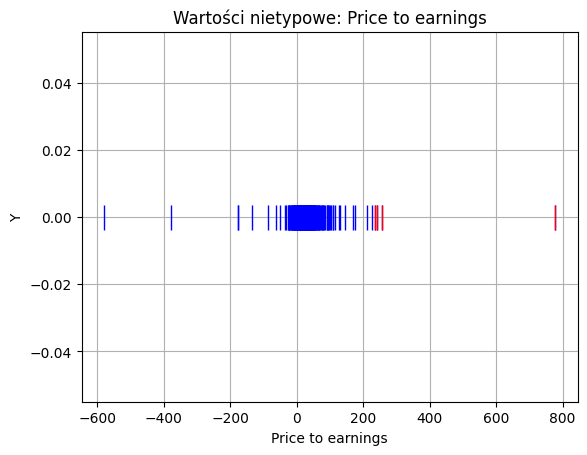

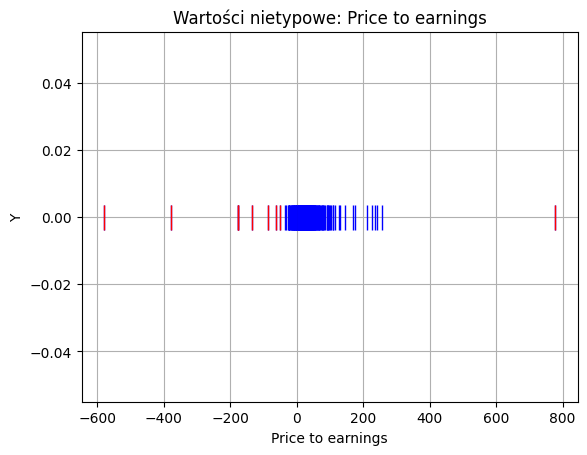

In [84]:
scatterplot_with_outliers_percentile_1D(price_to_earnings, 5, 95, 'Price to earnings')
scatterplot_with_outliers_1D(price_to_earnings, 10, 0.02, 'Price to earnings')

Text(0, 0.5, 'Price to earnings ratio')

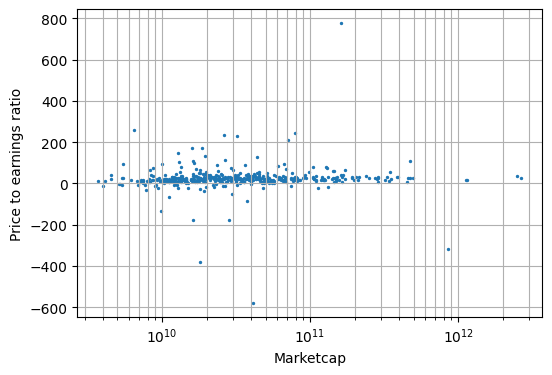

In [85]:
# Plot price to earnings ratio vs marketcaps
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, prince_to_earnings, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Price to earnings ratio')

Jak widać na wykresie, marektcap różni się znacznie między firmami. Ze względu na małą ilość próbek, odfiltrowaliśmy firmy o marketcapi > 50*10^10.

In [86]:
# Filter out pairs with marketcp > 5*10^11
marketcaps_filtered = marketcaps[marketcaps < 5*10**11]
prince_to_earnings_filtered = prince_to_earnings[marketcaps < 5*10**11]

Wskaźnik P/E jest z punktu widzenia naszej analizy problematyczny, ponieważ:
- Zakres wrtości jest bardzo duży (od ok. -600 do ok. 800)
- Firmy wykazujące pomijalnie mały zysk lub pomijalnie małą stratę mają dużą wartość bezwzględną wskaźnika P/E
- Firmy o podobnej wycenie, różniące się nieznacznie zyskami, są znacznie oddalone od siebie na osi P/E, podczas gdy firmy zacznie różniące się zyskami są blisko siebie. Jest to nieintuicyjne

Z tych powodów postanowiliśmy odwrócić wskaźnik (E/P = 1/(P/E)) i poddać go analizie

In [138]:
earnings_to_price_filtered = 1 / prince_to_earnings_filtered

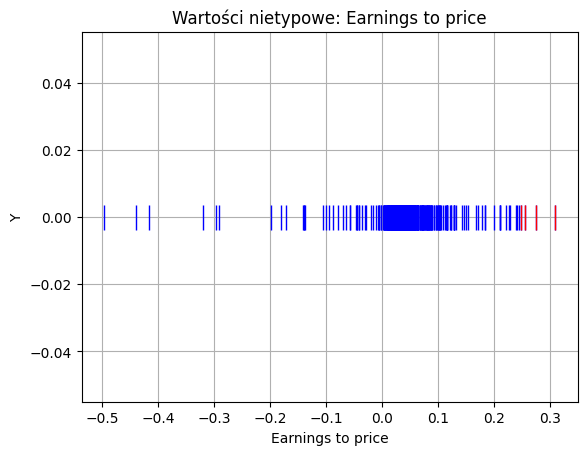

In [88]:
scatterplot_with_outliers_percentile_1D(earnings_to_price_filtered, 10, 90, 'Earnings to price')
# scatterplot_with_outliers_1D(earnings_to_price_filtered, 10, 0.02, 'Earnings to price')

Text(0, 0.5, 'Earnings to price ratio')

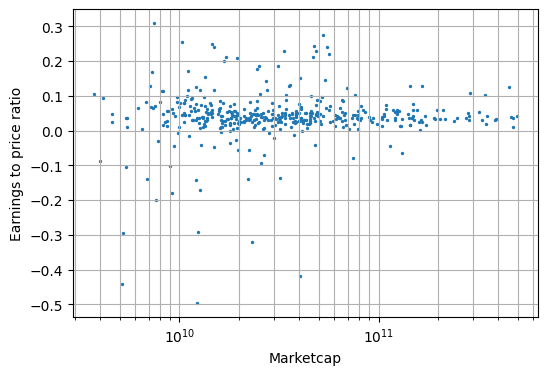

In [89]:
# Plot earnings to price ratio vs marketcaps
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps_filtered, earnings_to_price_filtered, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Earnings to price ratio')

Wnioski:
- Znaczna większość firm wykazuje zyski (E/P, P/E > 0).
- Niewiele jest firm z E/P > 0,1. Jeżeli jednak firma ma E/P większe niż 0,1 to z dużym prawdopodobieństwem jest ono znacznie więsze niż 0,1. Takie firmy mogą być dobrymi okazjami do inwestycji, o ile jej niska wycena nie wynika z problemów danej firmy.
- Jeżeli firma wykazuje stratę, to jest ona przeważnie bardzo duża w stosunku do wyceny rynkowej firmy. Możlie przyczyny:
  - Bardzo negatywna reakcja inwestorów na informaję o stratach i znaczny spadek wyceny
  - Straty mogą wynikać z niespodziwanych sytuacji o dużym wpływie na rentowność, których firma nie była w stanie przewidzieć, a co za tym idzie, zaadaptować się. Takie sytuacje prowadzą zwykle do dużych strat.
  - Straty wynikające z nagłych zdarzeń, awarii, katastrof itp. (fat tail)
- Bardzo duże firmy (> ok. 100 mld USD) żadko wykazują straty
- Im większa firma, tym mniejsze prawdopodobieństwo i skala strat (survivor bias? wzrost + lindy effect?)

Do E/P i wyceny dopasowaliśmy wielomian 8 stopnia, aby zobaczyć zależności.

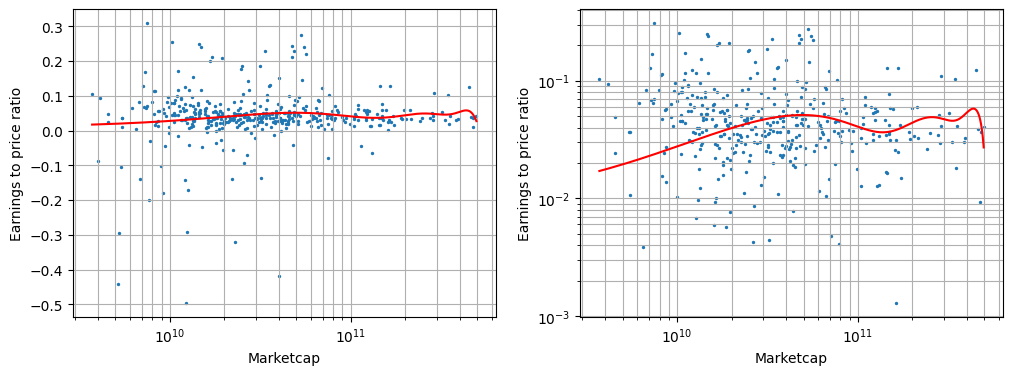

In [90]:
# Fit a polynomial to the data
polynomial_fit = np.polyfit(marketcaps_filtered, earnings_to_price_filtered, 8)

x = np.linspace(np.min(marketcaps_filtered), np.max(marketcaps_filtered), 1000)
polynomial_values = np.polyval(polynomial_fit, x)

fig, ax = get_fig_ax(num_cols=2, figsize=(12, 4))

ax[0].set_xlabel('Marketcap')
ax[0].set_ylabel('Earnings to price ratio')
ax[0].set_xscale('log')
ax[0].scatter(marketcaps_filtered, earnings_to_price_filtered, s=2)
ax[0].plot(x, polynomial_values, color='red')

ax[1].set_xlabel('Marketcap')
ax[1].set_ylabel('Earnings to price ratio')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].scatter(marketcaps_filtered, earnings_to_price_filtered, s=2)
ax[1].plot(x, polynomial_values, color='red')

Wnioski:
- E/P rośnie wraz z wyceną firmy do ok. 50 mld USD, potem maleje i osiąga lokalne miniumum powyżej 100 mld USD. Dalej rośnie, ale nie możemy z być tego pewni ze względu na małą lczność danych dla tak dużych firm.
- E/P dla małych firm jest zaniżane przez firmy wykazujące straty

# Some stuff

# TODO
- Podać jak zdefiniowaliśmy średni miesięczny i roczny spread

In [91]:
# Get average daily spread in a year for all tickers
for ticker in tickers:
    year = '2022'
    selected_flattened_financials[ticker]['spreadIn2022'] = financial_data[ticker]['quotes_stats'][year]['stats']['spread']
    selected_flattened_financials[ticker]['averageDailySpreadIn2022'] = financial_data[ticker]['quotes_stats'][year]['stats']['averageDailySpread']
    selected_flattened_financials[ticker]['averageMontlySpreadIn2022'] = financial_data[ticker]['quotes_stats'][year]['stats']['averageMonthlySpread']

In [134]:
# Get markecap and spread for all companies with:
# - marketcap not None
# - marketcap > 5*10^11
# - spread not None
marketcaps = []
spreads = []
for ticker in tickers:
    marketcap = selected_flattened_financials[ticker]['marketcap'] if 'marketcap' in selected_flattened_financials[ticker].keys() else None
    spread = selected_flattened_financials[ticker]['spreadIn2022'] if 'spreadIn2022' in selected_flattened_financials[ticker].keys() else None

    if marketcap is None:
        continue

    if marketcap > 5*10**11:
        continue

    if spread is None:
        continue

    marketcaps.append(marketcap)
    spreads.append(spread)

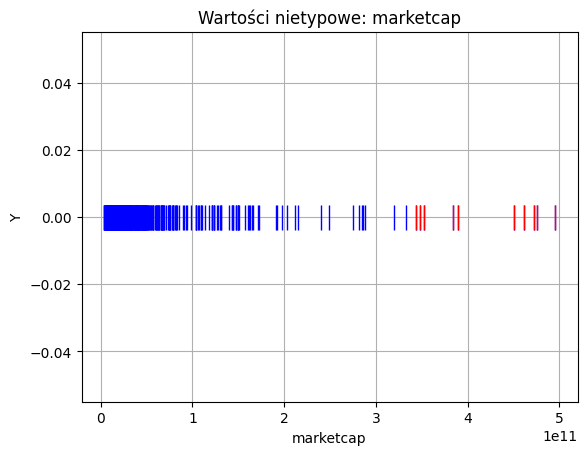

In [93]:
scatterplot_with_outliers_percentile_1D(marketcaps, 10, 90, 'marketcap')
# scatterplot_with_outliers_1D(marketcaps, 10, 0.02, 'marketcap')

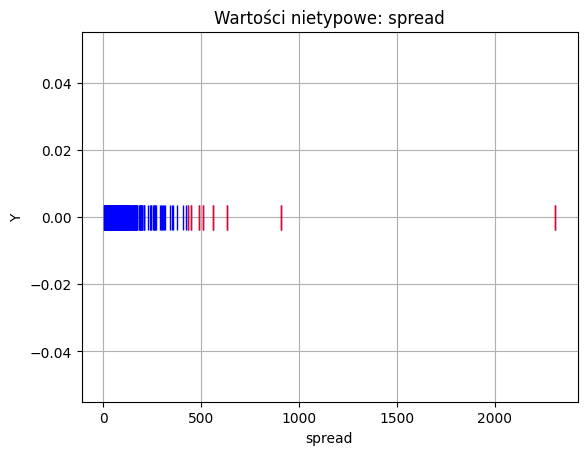

In [94]:
scatterplot_with_outliers_percentile_1D(spreads, 10, 90, 'spread')
# scatterplot_with_outliers_1D(spreads, 10, 0.02, 'spread')

Text(0, 0.5, 'Spread')

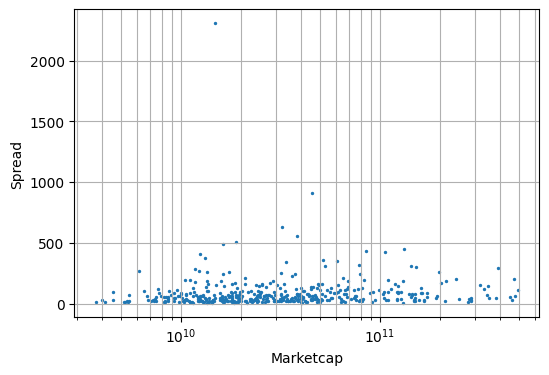

In [95]:
# Plot spread vs marketcap
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, spreads, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Spread')

# TODO
- Odfiltrować elementy nietypowe
- Wnioski o spreadzie w zależności od marketcapu (dopasowanie wielomianu?)

In [96]:
# Get average monthly spread and marketcap for all companies with:
# - marketcap not None
# - marketcap > 5*10^11
# - averageMonthlySpread not None
marketcaps = []
spreads = []
for ticker in tickers:
    marketcap = selected_flattened_financials[ticker]['marketcap'] if 'marketcap' in selected_flattened_financials[ticker].keys() else None
    spread = selected_flattened_financials[ticker]['averageMontlySpreadIn2022'] if 'averageMontlySpreadIn2022' in selected_flattened_financials[ticker].keys() else None

    if marketcap is None:
        continue

    if marketcap > 5*10**11:
        continue

    if spread is None:
        continue

    marketcaps.append(marketcap)
    spreads.append(spread)

Text(0, 0.5, 'Average monthly spread')

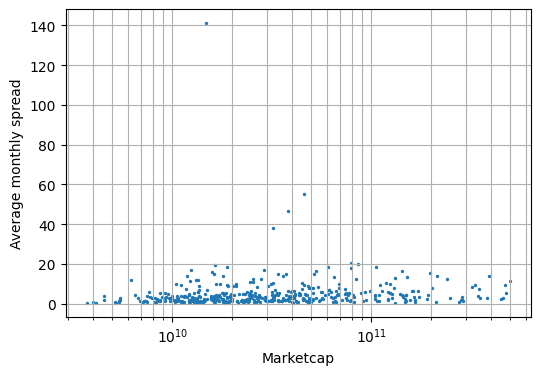

In [97]:
# Plot spread vs marketcap
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, spreads, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Average monthly spread')

# TODO
Jak dla spreadu

In [98]:
# Get average daily spread and marketcap for all companies with:
# - marketcap not None
# - marketcap > 5*10^11
# - averageDailySpread not None
marketcaps = []
spreads = []
for ticker in tickers:
    marketcap = selected_flattened_financials[ticker]['marketcap'] if 'marketcap' in selected_flattened_financials[ticker].keys() else None
    spread = selected_flattened_financials[ticker]['averageDailySpreadIn2022'] if 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() else None

    if marketcap is None:
        continue

    if marketcap > 5*10**11:
        continue

    if spread is None:
        continue

    marketcaps.append(marketcap)
    spreads.append(spread)

Text(0, 0.5, 'Average daily spread')

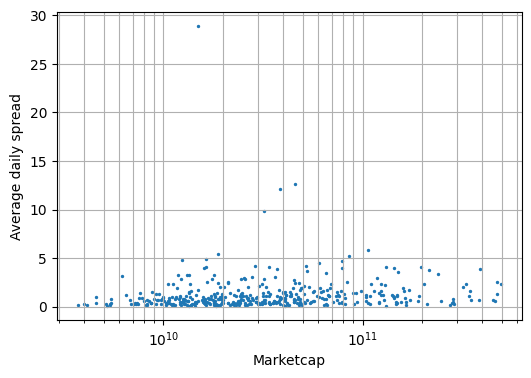

In [99]:
# Plot spread vs marketcap
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(marketcaps, spreads, s=2)
ax.set_xlabel('Marketcap')
ax.set_ylabel('Average daily spread')

# TODO
- Jak dla spreadu
- Znaleźć przyczyny dużego spreadu dla tych 4 wyróżniających się spółek

In [100]:
# For all tickers get the following:
# - net income margin
# - ebit margin
# - ebitda margin
# - debt to assets
# - net income to equity
# - net income to tangible book value
# - net income to assets
for ticker in tickers:
    # Get the latest timestamp for the annual markers
    latest_timestamp = get_latest_timestamp([list(i.keys())[0] for i in financial_data[ticker]['annual_markers']])

    if latest_timestamp == '0':
        continue

    for markers in financial_data[ticker]['annual_markers']:
        # Select markers with the latest timestamp
        if list(markers.keys())[0] == latest_timestamp:
            latest_markers = markers

    selected_flattened_financials[ticker]['netIncomeMargin'] = latest_markers[latest_timestamp]['netIncomeMargin']
    selected_flattened_financials[ticker]['ebitMargin'] = latest_markers[latest_timestamp]['ebitMargin']
    selected_flattened_financials[ticker]['ebitdaMargin'] = latest_markers[latest_timestamp]['ebitdaMargin']
    selected_flattened_financials[ticker]['debt/assets'] = latest_markers[latest_timestamp]['debt/assets']
    selected_flattened_financials[ticker]['netIncome/equity'] = latest_markers[latest_timestamp]['netIncome/equity']
    selected_flattened_financials[ticker]['netIncome/tangibleBookValue'] = latest_markers[latest_timestamp]['netIncome/tangibleBookValue']
    selected_flattened_financials[ticker]['netIncome/totalAssets'] = latest_markers[latest_timestamp]['netIncome/totalAssets']

In [101]:
# Get ebida margin, net income margin, and debt/assets for all companies with:
# - ebitdaMargin not None
# - netIncomeMargin not None
# - debt/assets not None
ebitda_margins = []
net_income_margins = []
debt_to_assets = []
for ticker in tickers:
    ebitda_margin = selected_flattened_financials[ticker]['ebitdaMargin'] if 'ebitdaMargin' in selected_flattened_financials[ticker].keys() else None
    net_income_margin = selected_flattened_financials[ticker]['netIncomeMargin'] if 'netIncomeMargin' in selected_flattened_financials[ticker].keys() else None
    debt_to_asset = selected_flattened_financials[ticker]['debt/assets'] if 'debt/assets' in selected_flattened_financials[ticker].keys() else None

    if ebitda_margin is None:
        continue

    if net_income_margin is None:
        continue

    if debt_to_asset is None:
        continue

    ebitda_margins.append(ebitda_margin)
    net_income_margins.append(net_income_margin)
    debt_to_assets.append(debt_to_asset)


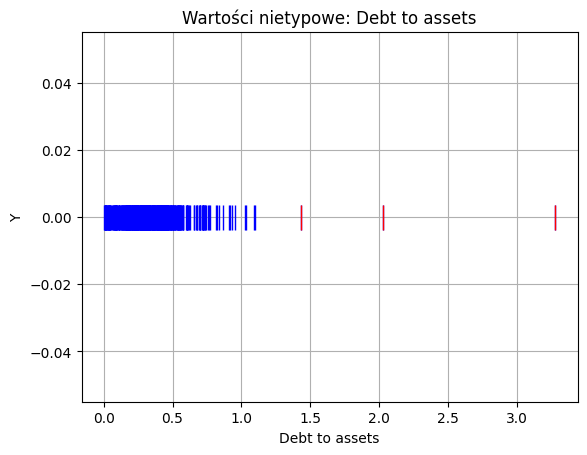

In [102]:
scatterplot_with_outliers_percentile_1D(debt_to_assets, 10, 90, 'Debt to assets')
# scatterplot_with_outliers_1D(debt_to_assets, 10, 0.02, 'Debt to assets')

Text(0, 0.5, 'Net income margin')

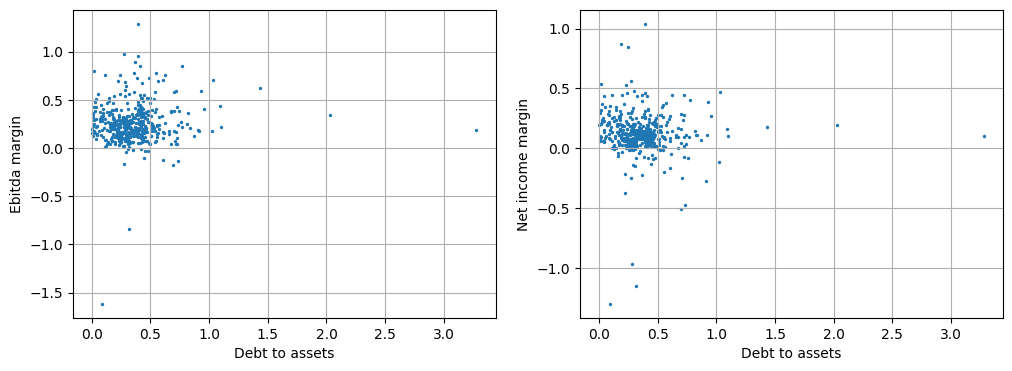

In [103]:
# Plot ebitda margin vs debt to assets and net income margin vs debt to assets
fig, ax = get_fig_ax(num_cols=2, figsize=(12, 4))

ax[0].scatter(debt_to_assets, ebitda_margins, s=2)
ax[0].set_xlabel('Debt to assets')
ax[0].set_ylabel('Ebitda margin')

ax[1].scatter(debt_to_assets, net_income_margins, s=2)
ax[1].set_xlabel('Debt to assets')
ax[1].set_ylabel('Net income margin')

Wniosek: nie ma zależności między marżą EBITDA i stosunkiem długu do aktywów

# TODO
Odfiltrować wartści nietypowe i dodać wykresy powyżej

# TODO
Wersja tego poniżej i wykresy bez filtrowania

In [104]:
# Get net income to equity, net income to tangible book value, debt to assets for all companies with:
# - netIncome/equity not None
# - netIncome/equity < 5 and > -5
# - netIncome/tangibleBookValue not None
# - netIncome/tangibleBookValue < 5 and > -5
# - debt/assets not None
# - debt/assets < 1.5
net_income_to_equities = []
net_income_to_tangible_book_values = []
debt_to_assets = []
for ticker in tickers:
    net_income_to_equity_value = selected_flattened_financials[ticker]['netIncome/equity'] if 'netIncome/equity' in selected_flattened_financials[ticker].keys() else None
    tangible_book_value_value = selected_flattened_financials[ticker]['netIncome/tangibleBookValue'] if 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() else None
    debt_to_asset = selected_flattened_financials[ticker]['debt/assets'] if 'debt/assets' in selected_flattened_financials[ticker].keys() else None

    if net_income_to_equity_value is None:
        continue

    if net_income_to_equity_value > 5 or net_income_to_equity_value < -5:
        continue

    if tangible_book_value_value is None:
        continue

    if tangible_book_value_value > 5 or tangible_book_value_value < -5:
        continue

    if debt_to_asset is None:
        continue

    if debt_to_asset > 1.5:
        continue

    net_income_to_equities.append(net_income_to_equity_value)
    net_income_to_tangible_book_values.append(tangible_book_value_value)
    debt_to_assets.append(debt_to_asset)

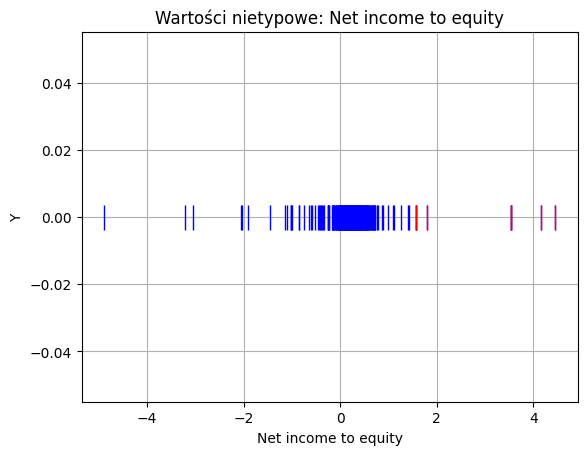

In [105]:
scatterplot_with_outliers_percentile_1D(net_income_to_equities, 10, 90, 'Net income to equity')
# scatterplot_with_outliers_1D(net_income_to_equities, 10, 0.02, 'Net income to equity')

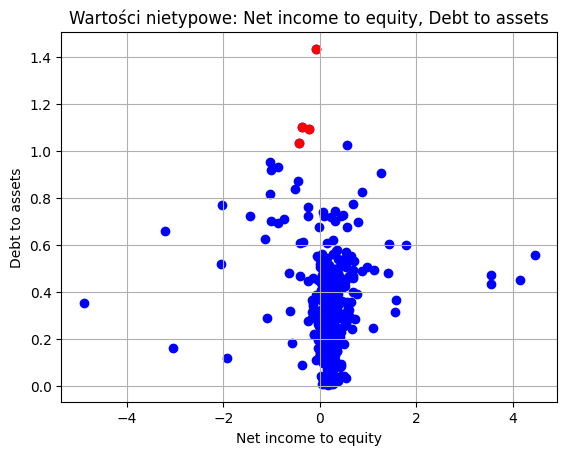

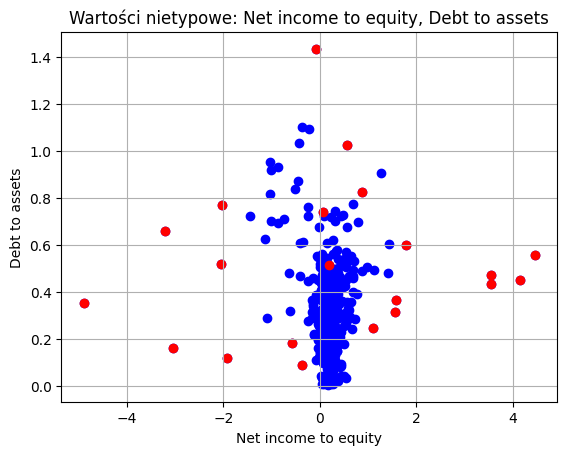

In [106]:
scatterplot_with_outliers_percentile_2D(net_income_to_equities, debt_to_assets, 15, 85, 'Net income to equity', 'Debt to assets')
scatterplot_with_outliers_2D(net_income_to_equities, debt_to_assets, 10, 0.05, 'Net income to equity', 'Debt to assets')

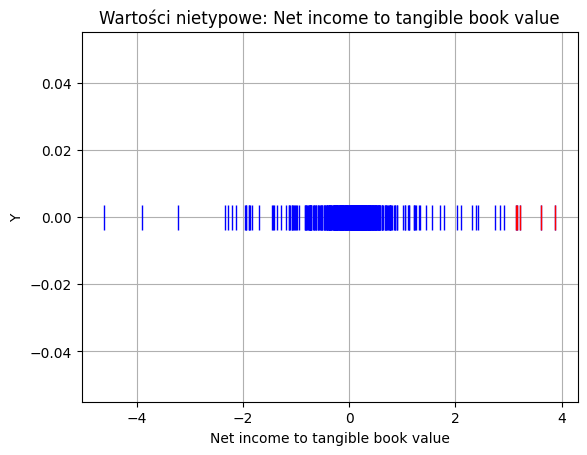

In [107]:
scatterplot_with_outliers_percentile_1D(net_income_to_tangible_book_values, 10, 90, 'Net income to tangible book value')
# scatterplot_with_outliers_1D(net_income_to_tangible_book_values, 10, 0.02, 'Net income to tangible book value')

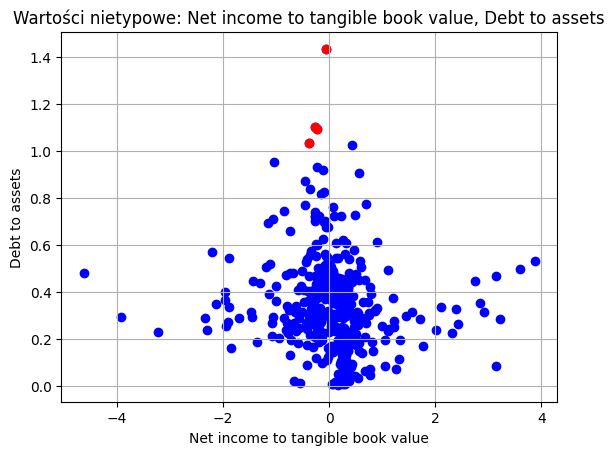

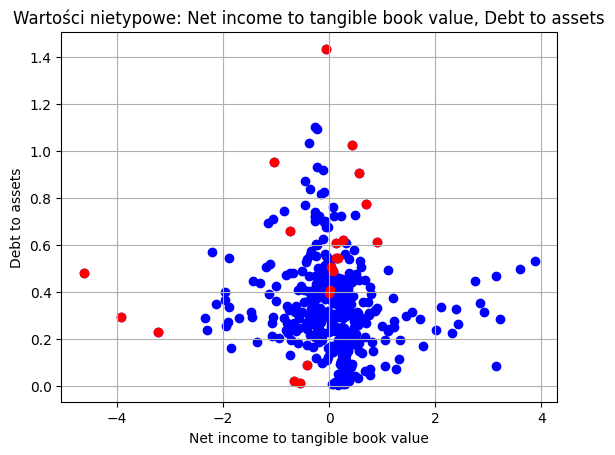

In [108]:
scatterplot_with_outliers_percentile_2D(net_income_to_tangible_book_values, debt_to_assets, 15, 85, 'Net income to tangible book value', 'Debt to assets')
scatterplot_with_outliers_2D(net_income_to_tangible_book_values, debt_to_assets, 10, 0.05, 'Net income to tangible book value', 'Debt to assets')

Text(0, 0.5, 'Net income to equity')

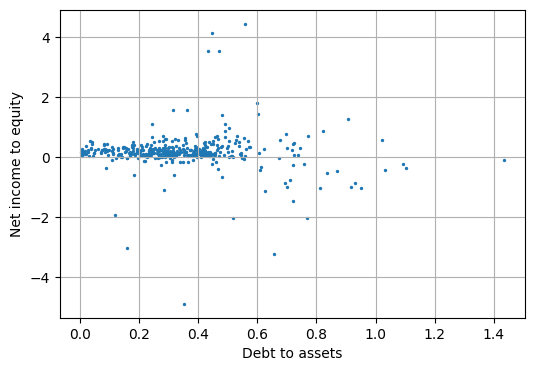

In [109]:
# Plot net income to equity vs debt to assets
fig, ax = get_fig_ax()
ax.scatter(debt_to_assets, net_income_to_equities, s=2)
ax.set_xlabel('Debt to assets')
ax.set_ylabel('Net income to equity')

Text(0, 0.5, 'Net income to tangible book value')

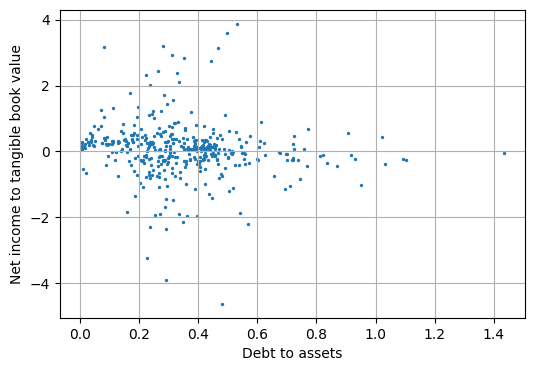

In [110]:
# plot net income to tangible book value vs debt to assets
fig, ax = get_fig_ax()
ax.scatter(debt_to_assets, net_income_to_tangible_book_values, s=2)
ax.set_xlabel('Debt to assets')
ax.set_ylabel('Net income to tangible book value')

Text(0, 0.5, 'Net income to tangible book value')

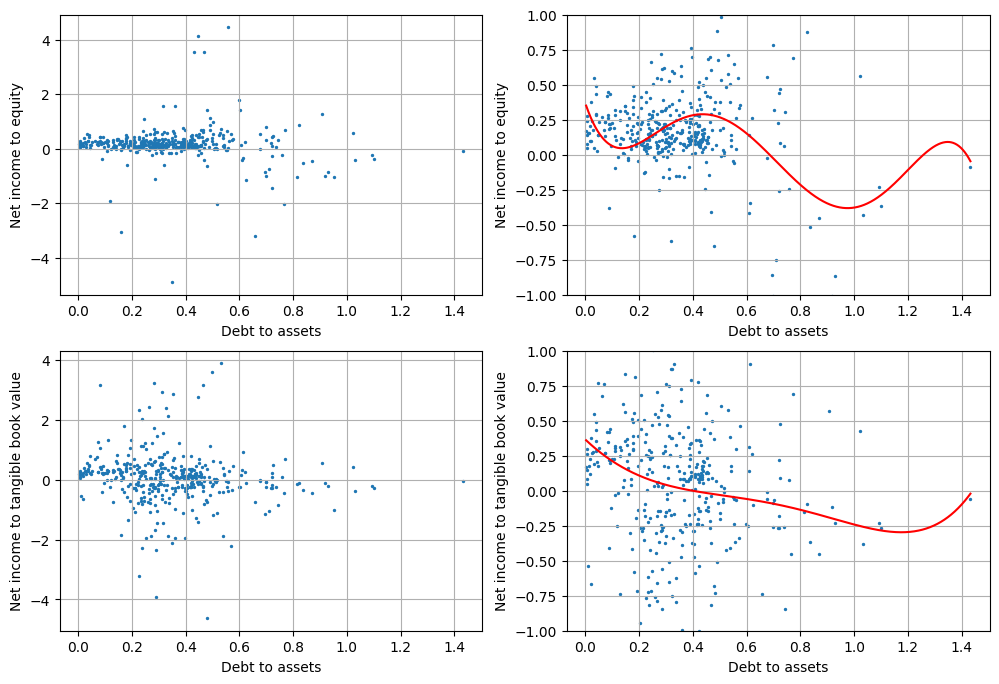

In [111]:
# Fit a polynomial to net income to equity vs debt to assets
net_income_to_equity_polynomial_fit = np.polyfit(debt_to_assets, net_income_to_equities, 5)

x = np.linspace(np.min(debt_to_assets), np.max(debt_to_assets), 1000)
net_income_to_equity_polynomial_values = np.polyval(net_income_to_equity_polynomial_fit, x)

# Fit a polynomial to net income to tangible book value vs debt to assets
net_income_to_tangible_book_value_polynomial_fit = np.polyfit(debt_to_assets, net_income_to_tangible_book_values, 5)

net_income_to_tangible_book_value_polynomial_values = np.polyval(net_income_to_tangible_book_value_polynomial_fit, x)

fig, ax = get_fig_ax(num_rows=2, num_cols=2, figsize=(12, 8))

ax[0, 0].scatter(debt_to_assets, net_income_to_equities, s=2)
ax[0, 0].set_xlabel('Debt to assets')
ax[0, 0].set_ylabel('Net income to equity')

ax[0, 1].scatter(debt_to_assets, net_income_to_equities, s=2)
ax[0, 1].plot(x, net_income_to_equity_polynomial_values, color='red')
ax[0, 1].set_ylim(-1, 1)
ax[0, 1].set_xlabel('Debt to assets')
ax[0, 1].set_ylabel('Net income to equity')

ax[1, 0].scatter(debt_to_assets, net_income_to_tangible_book_values, s=2)
ax[1, 0].set_xlabel('Debt to assets')
ax[1, 0].set_ylabel('Net income to tangible book value')

ax[1, 1].scatter(debt_to_assets, net_income_to_tangible_book_values, s=2)
ax[1, 1].plot(x, net_income_to_tangible_book_value_polynomial_values, color='red')
ax[1, 1].set_ylim(-1, 1)
ax[1, 1].set_xlabel('Debt to assets')
ax[1, 1].set_ylabel('Net income to tangible book value')

# ax[0].set_xlabel('Debt to assets')
# ax[0].set_ylabel('Net income to equity')
# ax[0].scatter(debt_to_assets, net_income_to_equity, s=2)

# ax[1].set_xlabel('Debt to assets')
# ax[1].set_ylabel('Net income to equity')
# ax[1].set_ylim(-1, 1)
# # ax[1].set_ylim(-2, 2)
# ax[1].scatter(debt_to_assets, net_income_to_equity, s=2)
# ax[1].plot(x, polynomial_values, color='red')

Wnioski:
- Wraz ze wzrostem stosunku długu do aktywów rośnie wartość bezwzględna stosunku zysku netto do wartości księgowej. Sugeruje to, że inwestycje w firmy o większym stosunku zadłużenia do aktywów są zarówno bardziej ryzykowne, jak i skutkują więszymi zyskami i stratami.
- Największego wzrostu skali działalnoci z reinwestycji zysków możemy spodziewać się dla przedziału stosunku długu do aktywów to 0,3 - 0,5.
- Stosunek zysku netto do wartości księgowej ma maksimum lokalne we wcześniej wymienionym przedziale. Później zaczyna spadać.
- Dla wartości księgowej z wyłączniem dóbr niematerialnych mamy w przybliżeniu rozkład gaussowski.
- Dla wartości księgowej z wyłączeniem dóbr niematerialnych widzimy jednostajny spadek stosunku zysku netto do wartości księgowej wraz ze wzrostem zadłuzenia.

In [112]:
# Get volume * price in a year for all tickers
for ticker in tickers:
    year = '2022'
    selected_flattened_financials[ticker]['volumePriceIn2022'] = financial_data[ticker]['quotes_stats'][year]['stats']['volumePrice']

In [113]:
# Get price to earnings ratio, volume * price, and marketcap for all companies with:
# - price/earnings not None
# - volumePrice not None
# - marketcap not None
# - marketcap < 5*10^11
price_to_earnings = []
volume_price = []
marketcaps = []
for ticker in tickers:
    price_to_earnings_value = selected_flattened_financials[ticker]['price/earnings'] if 'price/earnings' in selected_flattened_financials[ticker].keys() else None
    volume_price_value = selected_flattened_financials[ticker]['volumePriceIn2022'] if 'volumePriceIn2022' in selected_flattened_financials[ticker].keys() else None
    marketcap = selected_flattened_financials[ticker]['marketcap'] if 'marketcap' in selected_flattened_financials[ticker].keys() else None

    if price_to_earnings_value is None:
        continue

    if volume_price_value is None:
        continue

    if marketcap is None:
        continue

    if marketcap > 5*10**11:
        continue

    price_to_earnings.append(price_to_earnings_value)
    volume_price.append(volume_price_value)
    marketcaps.append(marketcap)

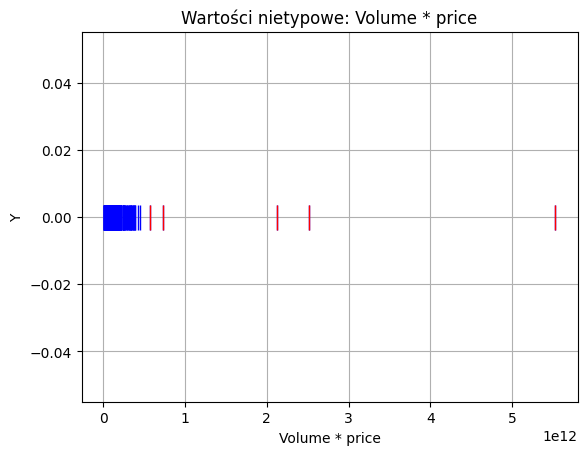

In [114]:
scatterplot_with_outliers_percentile_1D(volume_price, 10, 90, 'Volume * price')
# scatterplot_with_outliers_1D(volume_price, 10, 0.02, 'Volume * price')

In [115]:
earnings_to_price = [1 / i for i in price_to_earnings]

Text(0, 0.5, 'Earnings to price ratio')

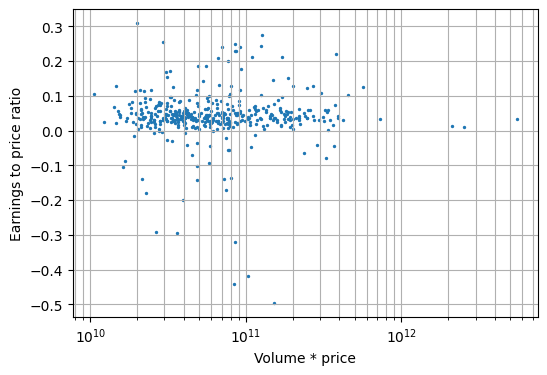

In [116]:
# Plot earnings to price ratio vs volume * price
fig, ax = get_fig_ax()
ax.set_xscale('log')
ax.scatter(volume_price, earnings_to_price, s=2)
ax.set_xlabel('Volume * price')
ax.set_ylabel('Earnings to price ratio')

In [117]:
volume_price_to_marketcap = [i / j for i, j in zip(volume_price, marketcaps)]

(0.0, 5.0)

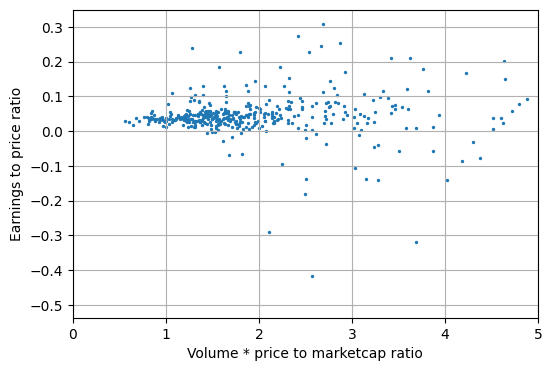

In [118]:
# Plot volume * price to marketcap ratio vs earnings to price ratio
fig, ax = get_fig_ax()
ax.scatter(volume_price_to_marketcap, earnings_to_price, s=2)
ax.set_xlabel('Volume * price to marketcap ratio')
ax.set_ylabel('Earnings to price ratio')
# limit x to 5
ax.set_xlim(0, 5)

# Macierz korelacji

In [169]:
marketcaps_full = np.array([selected_flattened_financials[ticker]['marketcap'] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys() and 'price/earnings' in selected_flattened_financials[ticker].keys() and 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() and 'netIncome/equity' in selected_flattened_financials[ticker].keys() and 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() and 'debt/assets' in selected_flattened_financials[ticker].keys() and 'volumePriceIn2022' in selected_flattened_financials[ticker].keys()])
price_to_earnings_full = np.array([[selected_flattened_financials[ticker]['price/earnings']] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys() and 'price/earnings' in selected_flattened_financials[ticker].keys() and 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() and 'netIncome/equity' in selected_flattened_financials[ticker].keys() and 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() and 'debt/assets' in selected_flattened_financials[ticker].keys() and 'volumePriceIn2022' in selected_flattened_financials[ticker].keys()])
earnings_to_price_full = 1 / price_to_earnings_full
spreads_full = np.array([selected_flattened_financials[ticker]['averageDailySpreadIn2022'] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys() and 'price/earnings' in selected_flattened_financials[ticker].keys() and 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() and 'netIncome/equity' in selected_flattened_financials[ticker].keys() and 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() and 'debt/assets' in selected_flattened_financials[ticker].keys() and 'volumePriceIn2022' in selected_flattened_financials[ticker].keys()])
net_income_to_equities_full = np.array([[selected_flattened_financials[ticker]['netIncome/equity']] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys() and 'price/earnings' in selected_flattened_financials[ticker].keys() and 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() and 'netIncome/equity' in selected_flattened_financials[ticker].keys() and 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() and 'debt/assets' in selected_flattened_financials[ticker].keys() and 'volumePriceIn2022' in selected_flattened_financials[ticker].keys()])
net_income_to_tangible_book_values_full = np.array([[selected_flattened_financials[ticker]['netIncome/tangibleBookValue']] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys() and 'price/earnings' in selected_flattened_financials[ticker].keys() and 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() and 'netIncome/equity' in selected_flattened_financials[ticker].keys() and 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() and 'debt/assets' in selected_flattened_financials[ticker].keys() and 'volumePriceIn2022' in selected_flattened_financials[ticker].keys()])
debt_to_assets_full = np.array([selected_flattened_financials[ticker]['debt/assets'] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys() and 'price/earnings' in selected_flattened_financials[ticker].keys() and 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() and 'netIncome/equity' in selected_flattened_financials[ticker].keys() and 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() and 'debt/assets' in selected_flattened_financials[ticker].keys() and 'volumePriceIn2022' in selected_flattened_financials[ticker].keys()])
volume_price_full = np.array([selected_flattened_financials[ticker]['volumePriceIn2022'] for ticker in tickers if 'marketcap' in selected_flattened_financials[ticker].keys() and 'price/earnings' in selected_flattened_financials[ticker].keys() and 'averageDailySpreadIn2022' in selected_flattened_financials[ticker].keys() and 'netIncome/equity' in selected_flattened_financials[ticker].keys() and 'netIncome/tangibleBookValue' in selected_flattened_financials[ticker].keys() and 'debt/assets' in selected_flattened_financials[ticker].keys() and 'volumePriceIn2022' in selected_flattened_financials[ticker].keys()])


In [181]:
data = pd.DataFrame({'net/eq': np.array(net_income_to_equities_full).flatten(), 'net/tangible': np.array(net_income_to_tangible_book_values_full).flatten(), 'debt/assets': np.array(debt_to_assets_full).flatten(), 'marketcap': np.array(marketcaps_full).flatten(), 'E/P': np.array(earnings_to_price_full).flatten(), 'spread': np.array(spreads_full).flatten(), 'volume': np.array(volume_price_full).flatten()})
corr = data.corr()

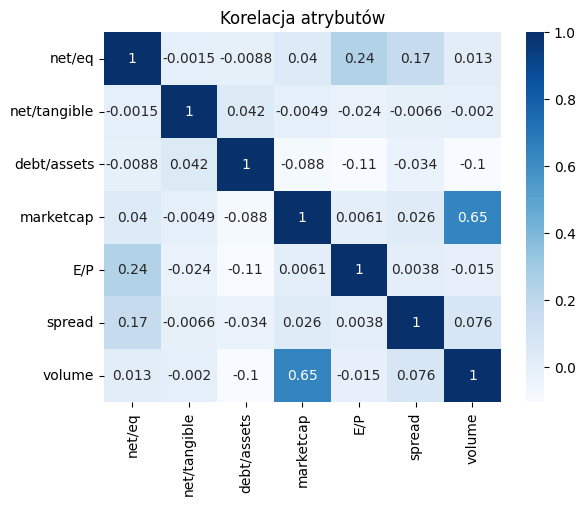

In [182]:
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Korelacja atrybutów')
plt.show()



# Klasteryzacja

In [223]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


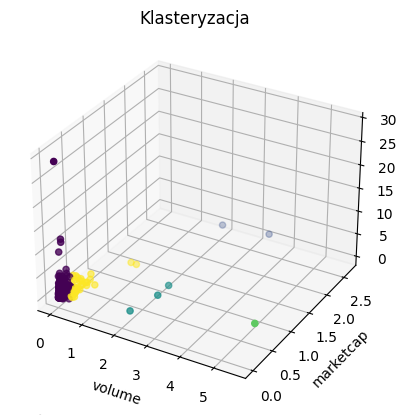

In [224]:
clusters_3D(data["volume"], data["marketcap"], data["spread"], clusters, "volume", "marketcap", "spread")

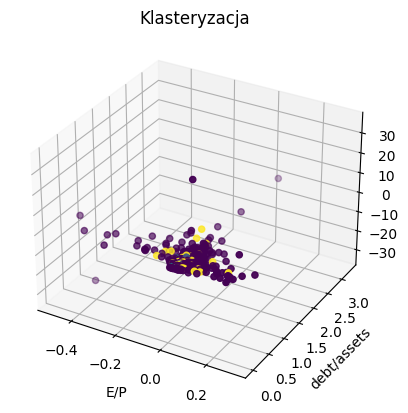

In [225]:
clusters_3D(data["E/P"], data["debt/assets"], data["net/eq"], clusters, "E/P", "debt/assets", "net/eq")

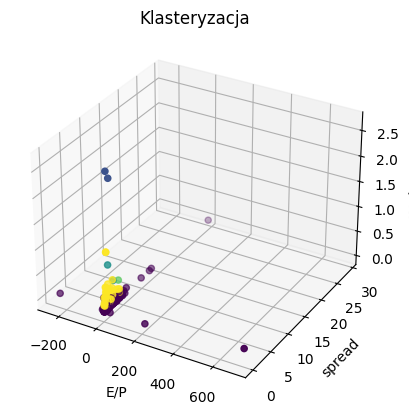

In [226]:
clusters_3D(data["net/tangible"], data["spread"], data["marketcap"], clusters, "E/P", "spread", "marketcap")

# Klasyfikacja

In [233]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, clusters, test_size=0.2)

# Utwórz klasyfikator
knn = KNeighborsClassifier(n_neighbors=5)

# Wytrenuj klasyfikator
knn.fit(X_train, y_train)

# Przetestuj klasyfikator
predictions = knn.predict(X_test)

# Wyświetl wyniki
accuracy = knn.score(X_test, y_test)
print(f"Dokładność klasyfikacji: {accuracy:.2f}")

Dokładność klasyfikacji: 0.98


<Axes: >

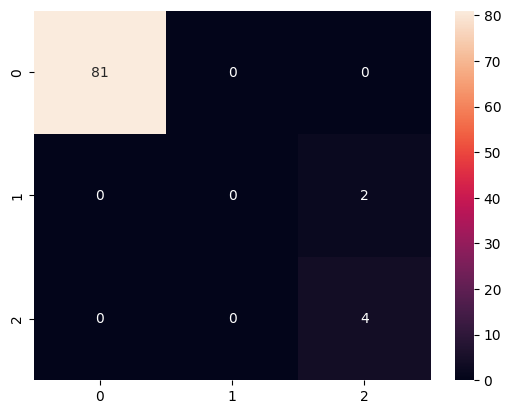

In [234]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True)